In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import datetime

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### Observation

Read cherry blossoms dataset for Tidal Basin, Washington DC. Records are available at https://cherryblossomwatch.com

In [3]:
cherry_dc = pd.read_hdf('./cherry_dc.h5')

In [4]:
cherry_dc.head()

Extension of Florets Florets Visible  \
station cultivar year                                        
DC      Kwanzan  1921                  NaT             NaT   
                 1922                  NaT             NaT   
                 1923                  NaT             NaT   
                 1924                  NaT             NaT   
                 1925                  NaT             NaT   

                      Green Color In Buds Peak Bloom Peduncle Elongation  \
station cultivar year                                                      
DC      Kwanzan  1921                 NaT 1921-04-17                 NaT   
                 1922                 NaT 1922-04-20                 NaT   
                 1923                 NaT 1923-04-22                 NaT   
                 1924                 NaT 1924-04-26                 NaT   
                 1925                 NaT 1925-04-15                 NaT   

                      Puffy White  
station cultivar year              
DC      Kwanzan  1921         NaT  
                 1922         NaT  
                 1923         NaT  
                 1924         NaT  
                 1925         NaT

We only use **Peak Bloom** dates of **Yoshino** cherry in the **DC** area.

In [5]:
obs = cherry_dc.loc['DC', 'Yoshino']['Peak Bloom']

In [6]:
obs

year
1921   1921-03-20
1922   1922-04-07
1923   1923-04-09
1924   1924-04-13
1925   1925-03-27
1926   1926-04-11
1927   1927-03-20
1928   1928-04-08
1929   1929-03-31
1930   1930-04-01
1931   1931-04-11
1932   1932-04-15
1933   1933-04-09
1934   1934-04-15
1935   1935-04-01
1936   1936-04-07
1937   1937-04-14
1938   1938-03-25
1939   1939-03-30
1940   1940-04-13
1941   1941-04-12
1942   1942-04-05
1943   1943-04-04
1944   1944-04-09
1945   1945-03-20
1946   1946-03-23
1947   1947-04-12
1948   1948-03-28
1949   1949-03-29
1950   1950-04-09
          ...    
1988   1988-03-31
1989   1989-03-29
1990   1990-03-15
1991   1991-03-29
1992   1992-04-07
1993   1993-04-11
1994   1994-04-05
1995   1995-04-02
1996   1996-04-04
1997   1997-03-26
1998   1998-03-27
1999   1999-04-05
2000   2000-03-17
2001   2001-04-06
2002   2002-04-02
2003   2003-04-02
2004   2004-03-31
2005   2005-04-09
2006   2006-03-30
2007   2007-04-01
2008   2008-03-29
2009   2009-04-01
2010   2010-03-31
2011   2011-03-29
2012 

By default, all timestamps are clocked at midnight (00:00). We want to change them to noon (12:00) for better dates handling. Keep in mind that phenology observations are usually made during daytime, not midnight.

In [7]:
obs = obs.apply(lambda t: t.replace(hour=12))

In [8]:
obs.tail()

year
2013   2013-04-09 12:00:00
2014   2014-04-10 12:00:00
2015   2015-04-10 12:00:00
2016   2016-03-25 12:00:00
2017   2017-03-25 12:00:00
Name: Peak Bloom, dtype: datetime64[ns]

In [9]:
obs[2017]

Timestamp('2017-03-25 12:00:00')

### Weather

Read weather dataset. Hourly data from weather stations are available at https://www7.ncdc.noaa.gov/CDO/cdopoemain.cmd?datasetabbv=DS3505

Stations codes
- 724050: Reagan National Airport
- 727930: Seattle-Tacoma International Airport

In [10]:
usa_ds3505 = pd.read_hdf('./usa_ds3505.h5')

In [11]:
usa_ds3505.head()

tavg
station timestamp                      
724050  1936-09-01 07:00:00-04:00  15.7
        1936-09-01 08:00:00-04:00  18.0
        1936-09-01 09:00:00-04:00  17.4
        1936-09-01 10:00:00-04:00  23.5
        1936-09-01 11:00:00-04:00  25.2

Weather records are originally in hourly interval and we want to convert them into daily interval for faster processing in this lab exercise. **724050** is the station code for Reagan National Airport which is located a few miles away from Tidal Basin, Washington DC.

In [12]:
met = usa_ds3505.loc[724050].resample('D').mean()

Remove timezone information from the weather dataset for easier manipulation in the later stage.

In [13]:
met.index = met.index.tz_localize(None)

In [14]:
met.tail()

,tavg
timestamp,
2017-09-26,24.866451
2017-09-27,27.315282
2017-09-28,24.516944
2017-09-29,19.216667
2017-09-30,18.066595


### Growing Degree Days Model (GDD)

The Growing Degree Days (GDD) is one of the most widely used models to describe a linear growth rate dependent on temperature forcing above a certain base temperature. When the weather records are limited to daily time scale, GDD often interpolates diurnal temperature from daily maximum and minimum temperatures, resulting into some variants of the method. We used growing degree hours (GDH) with hourly records to avoid such interpolation, but still described its parameters in daily scale for comparison with existing model parameters.

$$
\begin{aligned}
\Delta_h & = \begin{cases}
  \frac{1}{24} (T_h - T_b) & \text{if } T_h > T_b \\
  0 & \text{otherwise}
\end{cases} \\
\sum_{h=H_s}^{\hat{H}-1} \Delta_h & < R_d \leq \sum_{h=H_s}^{\hat{H}} \Delta_h
\end{aligned}
$$

#### Prepare weather data

Flowering for spring in the current year is a response to temperature changes during the past winter. Here we assume thermal accumulation for GDD model begins on the first day of the year.

In [15]:
def start_date(year):
    return datetime.date(year, 1, 1)

In [16]:
start_date(2017)

datetime.date(2017, 1, 1)

The end date of model simulation could be any date later than flowering dates which often occur during March or April. Here we decide to use May 31th.

In [17]:
def end_date(year):
    return datetime.date(year, 5, 31)

In [18]:
end_date(2017)

datetime.date(2017, 5, 31)

Now we can make a slice of weather data needed for one year of model simulation.

In [19]:
Th = met[start_date(2017):end_date(2017)].tavg
Th.head()

timestamp
2017-01-01    7.919167
2017-01-02    6.378611
2017-01-03    6.839524
2017-01-04    8.506944
2017-01-05    1.161957
Freq: D, Name: tavg, dtype: float64

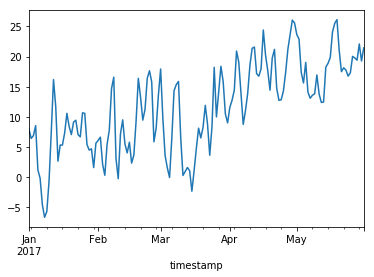

In [20]:
Th.plot()

#### Calculate thermal unit

In [21]:
def gdd(Th, Tb):
    return (Th - Tb).clip(lower=0).cumsum() #/ 24

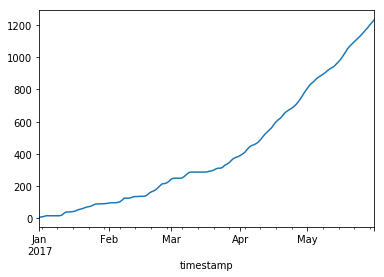

In [22]:
gdd(Th, 4).plot()

#### Match the requirement

`match` function finds the date when the cumulative thermal degree `D` reaches the thermal requirement `R`.

In [23]:
def match(D, R):
    i = D.searchsorted(R)[0]
    try:
        return D.index[i]
    except:
        return pd.NaT

In [24]:
match(gdd(Th, 4), 300)

Timestamp('2017-03-21 00:00:00', freq='D')

#### GDD estimation in one function

Let's put all in a function for predicting phenology based on GDD accumulation.

In [25]:
def gdd_estimate(met, year, params):
    Tb, Rd = params
    Th = met[start_date(year):end_date(year)].tavg
    D = gdd(Th, Tb)
    return match(D, Rd)

Our initial guess for 2017 cherry blossom is pretty close to what actually was.

In [26]:
gdd_estimate(met, 2017, (4, 300))

Timestamp('2017-03-21 00:00:00', freq='D')

In [27]:
obs[2017] - _

Timedelta('4 days 12:00:00')

#### Residual calculation

Let's make a function for calculating such difference or 'residual' which will be used in model parameterization.

In [28]:
def julian(t, year):
    #return int(t.strftime('%j'))
    return (t.year - year)*365 + float(t.strftime('%j')) + t.hour/24. + t.minute/(24*60.) + t.second/(24*60*60.)

def residual(met, obs, year, estimate, params):
    try:
        e = julian(estimate(met, year, params), year)
        o = julian(obs[year], year)
        return o - e
    except:
        return 365. # np.inf

In [29]:
residual(met, obs, 2017, gdd_estimate, (4, 300))

4.5

It will be handy to have a more general function to calculate residuals over multiple years of prediction.

In [30]:
def residuals(met, obs, years, estimate, params):
    return np.array([residual(met, obs, y, estimate, params) for y in years])

We will use 30 years of data from 1980 to 2009 for calibration.

In [31]:
years = range(1980, 2009+1)

In [32]:
r = residuals(met, obs, years, gdd_estimate, (4, 300))
r

array([ -3.5,   2.5, -11.5,  -2.5, -11.5,  -3.5,  -5.5, -19.5, -10.5,
       -15.5,  -0.5,  -4.5,  -6.5,  -9.5, -10.5,  -5.5, -11.5,  -3.5,
        -4.5,  -1.5,  -8.5,  -8.5,   2.5, -16.5, -14.5,  -3.5,  -3.5,
        -1.5,  -2.5, -15.5])

#### RMSE (Root-Mean-Square Error)

In [33]:
def rmse(r):
    return np.sqrt((r**2).mean())

In [34]:
rmse(r)

8.9990740264392386

#### EF (Model Efficiency)

First, make a helper function to get observation data from multiple years.

In [35]:
def observes(years):
    return np.array([julian(obs[y], y) for y in years])

Similarly, let's make a helper function for running multiple years of estimation. This will be used later in the notebook.

In [36]:
def estimates(met, years, estimate, params):
    return np.array([julian(estimate(met, y, params), y) for y in years])

In [37]:
estimates(met, years, gdd_estimate, (4, 300))

array([ 101.,   91.,  109.,  100.,  106.,  101.,   98.,  107.,  102.,
        104.,   75.,   93.,  105.,  111.,  106.,   98.,  107.,   89.,
         91.,   97.,   86.,  105.,   90.,  109.,  106.,  103.,   93.,
         93.,   92.,  107.])

In [38]:
def ef(r, o):
    do = o - o.mean()
    return 1 - np.sum(r**2) / np.sum(do**2)

In [39]:
o = observes(years)
o

array([  97.5,   93.5,   97.5,   97.5,   94.5,   97.5,   92.5,   87.5,
         91.5,   88.5,   74.5,   88.5,   98.5,  101.5,   95.5,   92.5,
         95.5,   85.5,   86.5,   95.5,   77.5,   96.5,   92.5,   92.5,
         91.5,   99.5,   89.5,   91.5,   89.5,   91.5])

Here is the model efficiency (EF) for GDD from our initial guess without parameter optimization. How would you interprete the model performance based on RMSE and EF?

In [40]:
ef(r, o)

-1.3749551956727162

## Model Parameterization

In [41]:
def cost(params, *args):
    return rmse(residuals(*args, params))

In [42]:
cost((4, 300), met, obs, years, gdd_estimate)

8.9990740264392386

#### Simplex Method (a.k.a., Nelder-Mead method)

In [43]:
def calibrate_nm(met, obs, years, estimate, func, params0):
    return scipy.optimize.minimize(
        fun=func,
        x0=params0,
        args=(met, obs, years, estimate),
        method='Nelder-Mead',
        options={
            'disp': True,
        }
    )
res = calibrate_nm(met, obs, years, gdd_estimate, cost, (4, 300))
res

Optimization terminated successfully.
         Current function value: 5.678908
         Iterations: 34
         Function evaluations: 97


 final_simplex: (array([[   3.72224121,  269.34814453],
       [   3.72224298,  269.34806049],
       [   3.72224188,  269.34811883]]), array([ 5.67890835,  5.67890835,  5.67890835]))
           fun: 5.6789083458002736
       message: 'Optimization terminated successfully.'
          nfev: 97
           nit: 34
        status: 0
       success: True
             x: array([   3.72224121,  269.34814453])

In [44]:
gdd_params_nm = tuple(res.x)

In [45]:
rmse(residuals(met, obs, years, gdd_estimate, gdd_params_nm))

5.6789083458002736

In [46]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_nm), observes(years))

0.054221382254228012

#### Differential Evolution

In [47]:
def calibrate_de(met, obs, years, estimate, func, bounds):
    return scipy.optimize.differential_evolution(
        func=func,
        bounds=bounds,
        args=(met, obs, years, estimate),
        disp=True,
    )
res = calibrate_de(met, obs, years, gdd_estimate, cost, ((0, 10), (0, 1000)))
res

differential_evolution step 1: f(x)= 5.74311
differential_evolution step 2: f(x)= 5.39599
differential_evolution step 3: f(x)= 5.39599
differential_evolution step 4: f(x)= 5.39599
differential_evolution step 5: f(x)= 5.39599
differential_evolution step 6: f(x)= 5.33385
differential_evolution step 7: f(x)= 5.33385
differential_evolution step 8: f(x)= 5.33385
differential_evolution step 9: f(x)= 5.24563
differential_evolution step 10: f(x)= 5.24563
differential_evolution step 11: f(x)= 5.23291
differential_evolution step 12: f(x)= 5.23291
differential_evolution step 13: f(x)= 5.23291
differential_evolution step 14: f(x)= 5.23291
differential_evolution step 15: f(x)= 5.22653
differential_evolution step 16: f(x)= 5.22653
differential_evolution step 17: f(x)= 5.22015
differential_evolution step 18: f(x)= 5.22015
differential_evolution step 19: f(x)= 5.1817
differential_evolution step 20: f(x)= 5.1817
differential_evolution step 21: f(x)= 5.1817
differential_evolution step 22: f(x)= 5.1817


     fun: 5.1816985632126462
 message: 'Optimization terminated successfully.'
    nfev: 693
     nit: 22
 success: True
       x: array([   7.81085117,  101.69927191])

In [48]:
gdd_params_de = tuple([  8.01380578,  96.2096106 ])

In [49]:
gdd_params_de = tuple(res.x)

In [50]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_de), observes(years))

0.21258431359770613

#### Brute-force (Generally, brute-force optimization can take a long time to complete so be prepared)

In [51]:
def calibrate_bf(met, obs, years, estimate, func, ranges):
    return scipy.optimize.brute(
        func=func,
        ranges=ranges,
        args=(met, obs, years, estimate),
        full_output=True,
        finish=scipy.optimize.fmin,
        disp=True,
    )
res = calibrate_bf(met, obs, years, gdd_estimate, cost, (slice(0, 10, 1), slice(0, 1000, 50)))
gdd_params_bf = tuple(res[0])

Optimization terminated successfully.
         Current function value: 5.383617
         Iterations: 22
         Function evaluations: 77


In [52]:
gdd_params_bf

(5.1953125, 192.8125)

In [53]:
ef(residuals(met, obs, years, gdd_estimate, gdd_params_bf), observes(years))

0.15002118022744315

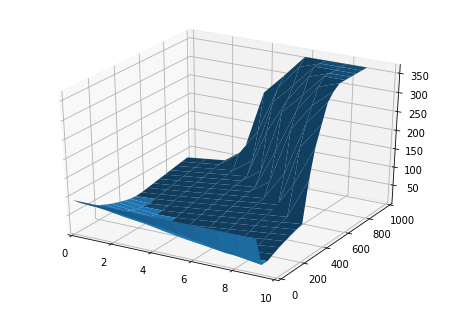

In [54]:
def plot_bf(res, xlim=None, ylim=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(res[2][0], res[2][1], res[3])
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    plt.show()
plot_bf(res, xlim=(0, 10), ylim=(0, 1000))

### Plotting the results

In [55]:
def plot(met, years, estimate, params):
    o = observes(years)
    e = estimates(met, years, gdd_estimate, gdd_params_de)
    return pd.DataFrame(
        data={'obs': o, 'est': e},
        index=years,
    ).plot()

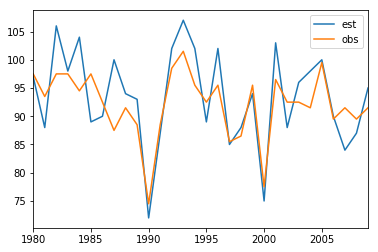

In [56]:
plot(met, years, gdd_estimate, gdd_params_de)

### Chilling and Forcing Model (CF)

Cesaraccio *et al.* split up dormancy break into two distinctive steps, rest and quiescence, that required the same amount of chilling and subsequent anti-chilling accumulation in the opposite direction. Later this model was extended to predict FBD coming after bud burst. The following equation represents our adaptation of this chilling and forcing (CF) model with three parameters: temperature threshold ($T_c$), chilling ($R_c$) and forcing ($R_f$) requirements. Unlike other forcing-only models, the starting date was implicitly set to October 1st of the previous year. Earlier dates are unlikely to impact model behavior much because the air temperature in September and before are mostly higher than the threshold ($T_c$), resulting in little or no chilling effect.

$$
\begin{aligned}
T'_h & = \begin{cases}
  T_h & \text{if } T_h \geq 0 \\
  0 & \text{otherwise}
\end{cases} \\
\Delta_h & = \frac{1}{24} (T'_h - T_c) \\
\Delta_h^{\mathtt{C}} & = \begin{cases}
  \Delta_h & \text{if } \Delta_h < 0 \\
  0 & \text{otherwise}
\end{cases} \\
\Delta_h^{\mathtt{F}} & = \begin{cases}
  \Delta_h & \text{if } \Delta_h > 0 \\
  0 & \text{otherwise}
\end{cases} \\
\sum_{h=H_s}^{\hat{H_0}-1} \Delta_h^{\mathtt{C}} & > R_d^{\mathtt{C}} \geq \sum_{h=H_s}^{\hat{H_0}} \Delta_h^{\mathtt{C}} \\
\sum_{h=\hat{H_0}}^{\hat{H}-1} \Delta_h^{\mathtt{F}} & < R_d^{\mathtt{F}} \leq \sum_{h=\hat{H_0}}^{\hat{H}} \Delta_h^{\mathtt{F}} \\
\end{aligned}
$$

As the CF model takes account of dormancy break due to chilling effect, we should take a longer period of weather data than what we used for GDD model above. We assume October 1st as a starting date of thermal accumulation for the CF model.

In [57]:
def cf_start_date(year):
    return datetime.date(year-1, 10, 1)

In [58]:
Thp = met[cf_start_date(2017):end_date(2017)].tavg.clip(lower=0)

In [59]:
def chill(Th, Tc):
    return (Th - Tc).clip(upper=0).cumsum() #/ 24

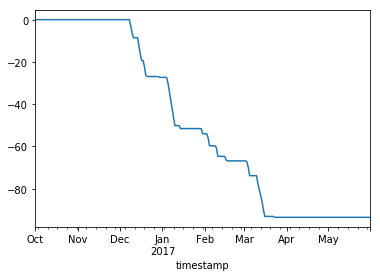

In [60]:
chill(Thp, 4).plot()

In [61]:
def antichill(Th, Tc):
    return (Th - Tc).clip(lower=0).cumsum() #/ 24

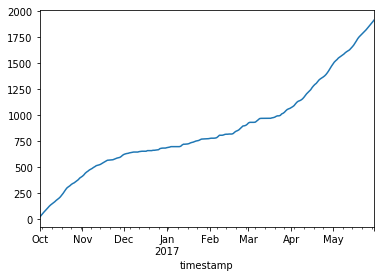

In [62]:
antichill(Thp, 4).plot()

In [63]:
def cf_estimate(met, year, params):
    Tc, Rc, Rf = params
    Thp = met[cf_start_date(year):end_date(year)].tavg.clip(lower=0)
    Dc = chill(Thp, Tc)
    m = match(-Dc, -Rc)
    # force release dormancy even if chilling requirement is not fully satisfied
    if pd.isnull(m):
        m = pd.Timestamp(year, 3, 1)
    Df = antichill(Thp.loc[m:], Tc)
    return match(Df, Rf)

In [64]:
cf_estimate(met, 2017, (4, -100, 200))

Timestamp('2017-04-05 00:00:00', freq='D')

In [65]:
obs[2017]

Timestamp('2017-03-25 12:00:00')

In [66]:
res = calibrate_nm(met, obs, years, cf_estimate, cost, (4, -100, 200))
cf_params_nm = tuple(res.x)
res

Optimization terminated successfully.
         Current function value: 5.044799
         Iterations: 31
         Function evaluations: 103


 final_simplex: (array([[   4.22125057, -106.28486511,  192.60631001],
       [   4.22124931, -106.28483058,  192.60637481],
       [   4.22125248, -106.28480583,  192.60625016],
       [   4.22125074, -106.28480496,  192.60635521]]), array([ 5.0447993,  5.0447993,  5.0447993,  5.0447993]))
           fun: 5.044799302251775
       message: 'Optimization terminated successfully.'
          nfev: 103
           nit: 31
        status: 0
       success: True
             x: array([   4.22125057, -106.28486511,  192.60631001])

In [67]:
res = calibrate_de(met, obs, years, cf_estimate, cost, ((0, 10), (-200, 0), (0, 1000)))
cf_params_de = tuple(res.x)
res

differential_evolution step 1: f(x)= 4.7662
differential_evolution step 2: f(x)= 4.31856
differential_evolution step 3: f(x)= 4.31856
differential_evolution step 4: f(x)= 4.22493
differential_evolution step 5: f(x)= 4.08044
differential_evolution step 6: f(x)= 4.08044
differential_evolution step 7: f(x)= 4.08044
differential_evolution step 8: f(x)= 4.04763
differential_evolution step 9: f(x)= 4.04763
differential_evolution step 10: f(x)= 4.02285
differential_evolution step 11: f(x)= 4.02285
differential_evolution step 12: f(x)= 4.00625
differential_evolution step 13: f(x)= 3.95601
differential_evolution step 14: f(x)= 3.95601
differential_evolution step 15: f(x)= 3.95601
differential_evolution step 16: f(x)= 3.95601
differential_evolution step 17: f(x)= 3.95601
differential_evolution step 18: f(x)= 3.95601
differential_evolution step 19: f(x)= 3.95601
differential_evolution step 20: f(x)= 3.93912
differential_evolution step 21: f(x)= 3.93912
differential_evolution step 22: f(x)= 3.9391

     fun: 3.9391200370979642
 message: 'Optimization terminated successfully.'
    nfev: 1129
     nit: 24
 success: True
       x: array([   1.31985519,  -86.98019262,  229.97233402])

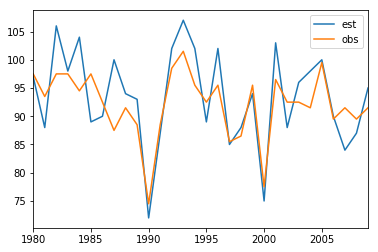

In [68]:
plot(met, years, cf_estimate, cf_params_de)

### GDD vs. CF

#### Calibration Results

In [69]:
r_gd_de = residuals(met, obs, years, gdd_estimate, gdd_params_de)
r_cf_de = residuals(met, obs, years, cf_estimate, cf_params_de)
o = observes(years)

##### RMSE

In [70]:
rmse(r_gd_de)

5.1816985632126462

In [71]:
rmse(r_cf_de)

3.9391200370979642

##### EF

In [72]:
ef(r_gd_de, o)

0.21258431359770613

In [73]:
ef(r_cf_de, o)

0.54495095962722806

#### Testing Results

Let's test (or validate) the models with a different dataset than the one used for calibration. Ideally, we need a completely independent dataset, but here we keep using the same dataset, but selecting years not seen for calibration.

In [74]:
testing_years = range(2010, 2017+1)

In [75]:
testing_r_gd_de = residuals(met, obs, testing_years, gdd_estimate, gdd_params_de)
testing_r_cf_de = residuals(met, obs, testing_years, cf_estimate, cf_params_de)
testing_o = observes(testing_years)

##### RMSE

In [76]:
rmse(testing_r_gd_de)

10.428326807307105

In [77]:
rmse(testing_r_cf_de)

4.9749371855330997

##### EF

In [78]:
ef(testing_r_gd_de, testing_o)

-0.97055492638731589

In [79]:
ef(testing_r_cf_de, testing_o)

0.55152887882219703

##### AIC

In [80]:
def aic(r, k):
    n = len(r)
    ssr = (r**2).sum()
    s2 = ssr / n
    L = (1 / np.sqrt(2*np.pi*s2))**n * np.exp(-ssr / (2*s2))
    return 2*k - 2*np.log(L)

Number of parameters for each model.

In [81]:
gd_k = 2
cf_k = 3

In [82]:
aic(testing_r_gd_de, gd_k)

64.21542989102511

In [83]:
aic(testing_r_cf_de, cf_k)

54.373620443392362

### UW Cherry Blossom

In [84]:
def read_cherry_uw():
    df = pd.read_excel(
        io='./Cherry_PBD_2017.xls',
        sheetname='UW',
    )
    s = df.set_index('year').stack()
    s.index.names = ['year', 'cultivar']
    s.name = 'bloom'
    df = s.reset_index()
    df['bloom'] = df.apply(lambda r: pd.datetime.strptime(f'{r.year}-{r.bloom}', '%Y-%j'), axis=1)
    df['station'] = 'UW'
    return df.set_index(['station', 'cultivar', 'year'])
cherry_uw = read_cherry_uw()

In [85]:
cherry_uw.tail()

bloom
station cultivar year           
UW      Yoshino  2013 2013-03-27
                 2014 2014-03-21
                 2015 2015-03-16
                 2016 2016-03-07
                 2017 2017-03-27

In [86]:
obs = cherry_uw.loc['UW', 'Yoshino']['bloom']

We use weather records from SeaTac aiport to predict flowering on the UW campus. Data from Sandpoint station (94290) would have been a better choice, but unfortunately they were not available at the time of writing this notebook.

In [87]:
met = usa_ds3505.loc[727930].resample('D').mean()
met.index = met.index.tz_localize(None)

In [89]:
met.head()

,tavg
timestamp,
1948-01-01,8.000000
1948-01-02,4.995833
1948-01-03,4.808333
1948-01-04,4.537500
1948-01-05,4.079167


In [90]:
obs

year
1994   1994-04-02
1996   1996-04-15
2005   2005-03-31
2006   2006-04-13
2007   2007-04-10
2008   2008-04-10
2009   2009-04-17
2010   2010-04-03
2011   2011-04-13
2012   2012-04-02
2013   2013-03-27
2014   2014-03-21
2015   2015-03-16
2016   2016-03-07
2017   2017-03-27
Name: bloom, dtype: datetime64[ns]